In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import os
%matplotlib inline

In [224]:
# set status of buys as 1
buys=pd.read_csv('yoochoose-buys.dat',names=['sessionID','ts','itemID','price','quantity'])
print("buys shape",buys.shape)
buys['status']=1

# set status of clicks as 0
clicks=pd.read_csv('yoochoose-clicks.dat',names=['sessionID','ts','itemID','category'])
print("clicks shape",clicks.shape)
clicks['status']=0

# concat two kinds of data set,sorted by sessionID and itemID
union=pd.concat([clicks, buys], ignore_index=True).sort_values(by=['sessionID','itemID'])
print("union shape",union.shape)
union.head()

buys shape (1150753, 5)


/Users/sumedhtelang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


clicks shape (33003944, 4)


/Users/sumedhtelang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':


union shape (34154697, 7)


,category,itemID,price,quantity,sessionID,status,ts
1,0,214536500,NaN,NaN,1,0,2014-04-07T10:54:09.868Z
0,0,214536502,NaN,NaN,1,0,2014-04-07T10:51:09.277Z
2,0,214536506,NaN,NaN,1,0,2014-04-07T10:54:46.998Z
3,0,214577561,NaN,NaN,1,0,2014-04-07T10:57:00.306Z
9,0,214551617,NaN,NaN,2,0,2014-04-07T14:02:36.889Z


In [225]:
# ts to datetime
union['ts']=pd.to_datetime(union.ts,infer_datetime_format=True)

In [226]:
union.head(12345).groupby(["itemID","sessionID"])["status"].nunique().max()

2

In [227]:
# replace NaNs of cat by preceding values in the same item group 
union['category']=union['category'].fillna(method='ffill')

### ts to datetime
# union['ts']=pd.to_datetime(union.ts,infer_datetime_format=True)
union['hour']=union.ts.dt.hour
union['weekday']=union['ts'].dt.dayofweek.astype(int)+1


In [228]:
union.head()

,category,itemID,price,quantity,sessionID,status,ts,hour,weekday
1,0,214536500,NaN,NaN,1,0,2014-04-07 10:54:09.868,10,1
0,0,214536502,NaN,NaN,1,0,2014-04-07 10:51:09.277,10,1
2,0,214536506,NaN,NaN,1,0,2014-04-07 10:54:46.998,10,1
3,0,214577561,NaN,NaN,1,0,2014-04-07 10:57:00.306,10,1
9,0,214551617,NaN,NaN,2,0,2014-04-07 14:02:36.889,14,1


In [229]:
buyID_num = buys.sessionID.nunique() #
buyEvents = buys.shape[0]
clickID_num = clicks.sessionID.nunique()
itemClicks = clicks.shape[0]
BC_ratio = buyID_num/clickID_num

In [230]:
print(r'''BuyID_num:{} 
Buy_Events:{} 
ClickID_num:{} 
Item_Clicks:{} 
Buy Ratio of Sessions :{}
Buy Ratio of Clicks:{}'''
.format(buyID_num,buyEvents,clickID_num,itemClicks,BC_ratio,buyEvents/clickID_num))

BuyID_num:509696 
Buy_Events:1150753 
ClickID_num:9249729 
Item_Clicks:33003944 
Buy Ratio of Sessions :0.05510388466516154
Buy Ratio of Clicks:0.1244093745881636


In [231]:
buyEvents/clickID_num

0.1244093745881636

Statistics

In [232]:
# Buy ratio averaged for hour
hour_info=union.groupby(['hour','status'])['sessionID'].nunique().reset_index(name='count')
hour_click=hour_info[hour_info['status']==0]
hour_buy=hour_info[hour_info['status']==1]
hour_info=pd.merge(hour_click,hour_buy,on='hour')
hour_info['ratio']=hour_info['count_y']/hour_info['count_x']

In [233]:
# Buy ratio averaged for weekday
weekday_info=union.groupby(['weekday','status'])['sessionID'].nunique().reset_index(name='count')
weekday_click=weekday_info[weekday_info['status']==0]
weekday_buy=weekday_info[weekday_info['status']==1]
weekday_info=pd.merge(weekday_click,weekday_buy,on='weekday')
weekday_info['ratio']=weekday_info.count_y/weekday_info.count_x

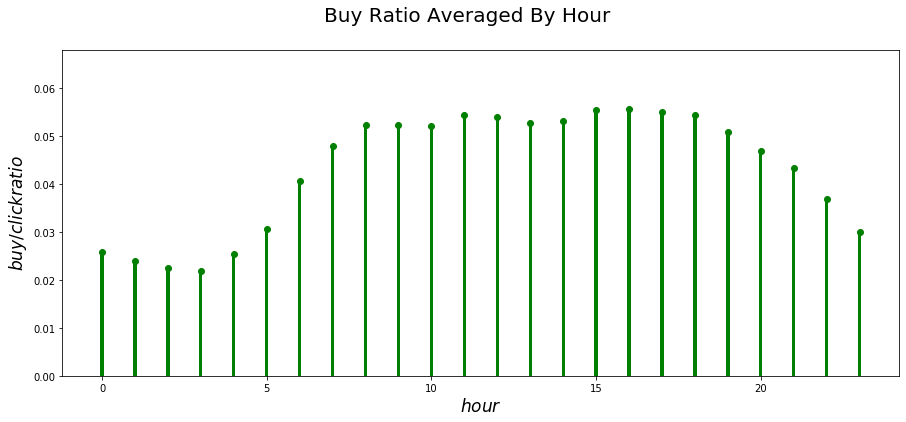

In [234]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('Buy Ratio Averaged By Hour', fontsize=20)

ax1 = fig.add_subplot()

ax1.scatter(hour_info['hour'],hour_info['ratio'],color='g')
ax1.bar(hour_info['hour'],hour_info['ratio'],width=0.1,color='g')


ax1.set_xlabel('$hour$', fontsize=17)
ax1.set_ylabel('$buy/click ratio$', fontsize=17)
plt.show()

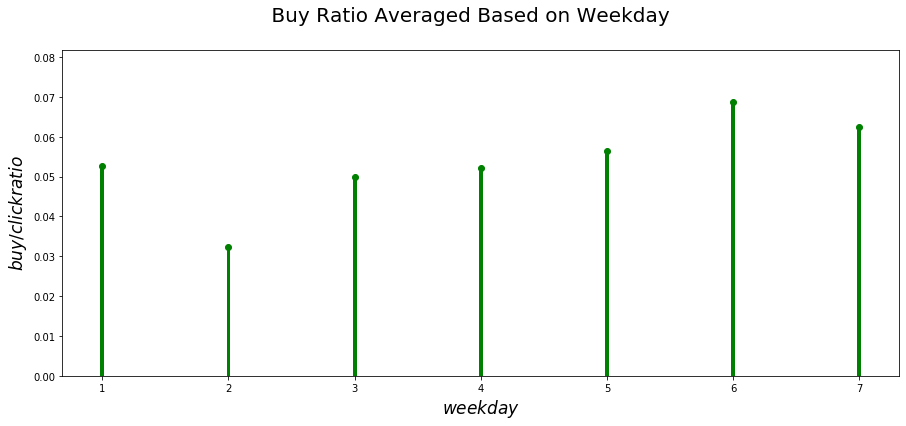

In [235]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged Based on Weekday', fontsize=20)

ax2 = fig.add_subplot()

ax2.scatter(weekday_info['weekday'],weekday_info['ratio'],color='g')
ax2.bar(weekday_info['weekday'],weekday_info['ratio'],width=0.03,color='g')
ax2.set_xlabel('$weekday$', fontsize=17)
ax2.set_ylabel('$buy/click ratio$', fontsize=17)
plt.show()

In [236]:
def category_classfier(value):
    if value=='S':
        return '13'
    elif len(value)<=2:
        return value
    else:
        return '14'

In [237]:
union['category']=union.category.astype(str).apply(category_classfier).astype(int)
category_info=union.groupby(['category','status'])['sessionID'].nunique().reset_index(name='count').sort_values(by='category')
category_click=category_info[category_info['status']==0]
category_buy=category_info[category_info['status']==1]
category_info=pd.merge(category_click,category_buy,on='category')
category_info['ratio']=category_info.count_y/category_info.count_x

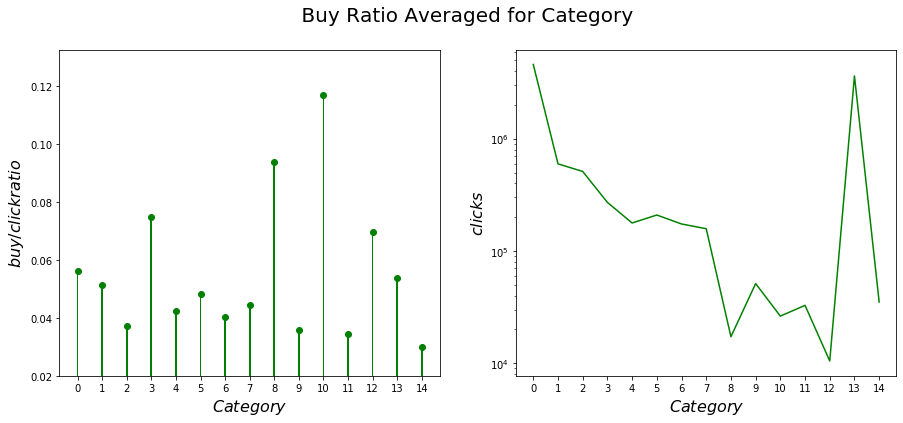

<Figure size 576x288 with 0 Axes>

In [238]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Category', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


fig = plt.figure(figsize=(8,4))
# plt.plot(cat_info.count_y)
ax1.scatter(category_info.category,category_info.ratio,color='g')
ax1.bar(category_info.category,category_info.ratio,width=0.07,color='g')
ax1.set_xticks(range(0,15))
ax1.set_ylim(0.02)
ax1.set_ylabel('$buy/click ratio$',fontsize=16)
ax1.set_xlabel('$Category$',fontsize=16)

ax2.plot(category_info.count_x,color='g')
ax2.set_yscale('log')
ax2.set_ylabel('$clicks$',fontsize=16)
ax2.set_xticks(range(0,15))
ax2.set_xlabel('$Category$',fontsize=16)

plt.show()

In [239]:
# clear unused variables
import gc
del buys,clicks
gc.collect()

22413

In [240]:
category=union[['sessionID','category','status']]
category_num=category.groupby('sessionID')['category'].nunique().reset_index(name='category_num')
session_status=category.groupby('sessionID')['status'].max().reset_index(name='status')
category_info=pd.merge(category_num,session_status,on='sessionID')

In [241]:
category_buys=category_info.groupby('category_num')['status'].sum().reset_index(name='buys')
category_nums=category_info.groupby('category_num')['status'].count().reset_index(name='session_nums')
category_aggr=pd.merge(category_buys,category_nums,on='category_num')
category_aggr['ratio']=category_aggr.buys/category_aggr.session_nums

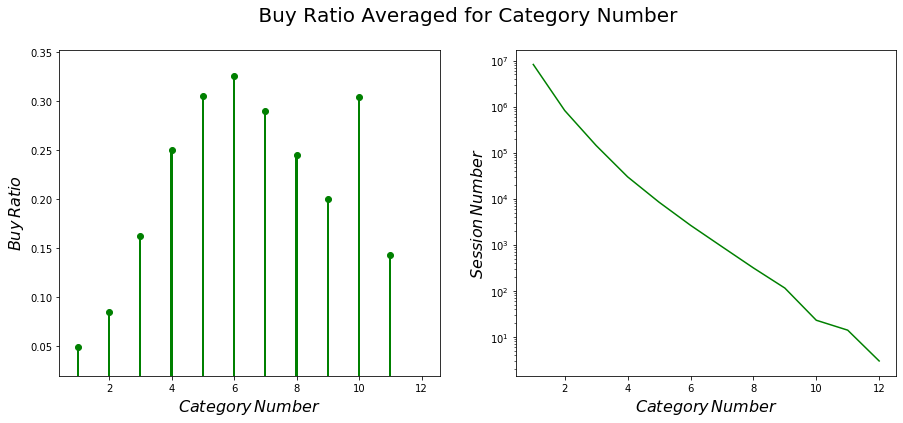

<Figure size 576x288 with 0 Axes>

In [242]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Category Number', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


fig = plt.figure(figsize=(8,4))
ax1.scatter(category_aggr.category_num,category_aggr.ratio,color='g')
ax1.bar(category_aggr.category_num,category_aggr.ratio,color='g',width=0.07)
ax1.set_ylim(0.02)
ax1.set_ylabel('$Buy\,Ratio$',fontsize=16)
ax1.set_xlabel('$Category \,Number$',fontsize=16)


ax2.plot(category_aggr.category_num,category_aggr.session_nums,color='g')
ax2.set_yscale('log')
ax2.set_ylabel('$Session\,Number$',fontsize=16)
ax2.set_xlabel('$Category\,Number$',fontsize=16)

plt.show()

In [243]:
session_length=union.groupby('sessionID')['status'].count().reset_index(name='length')
session_length=pd.merge(session_status,session_length,on='sessionID')

In [244]:
len_buys=session_length.groupby('length')['status'].sum().reset_index(name='buys')
len_num=session_length.groupby('length')['status'].count().reset_index(name='len_num')
len_aggr=pd.merge(len_buys,len_num,on='length')

In [245]:
len_aggr['ratio']=len_aggr.buys/len_aggr.len_num

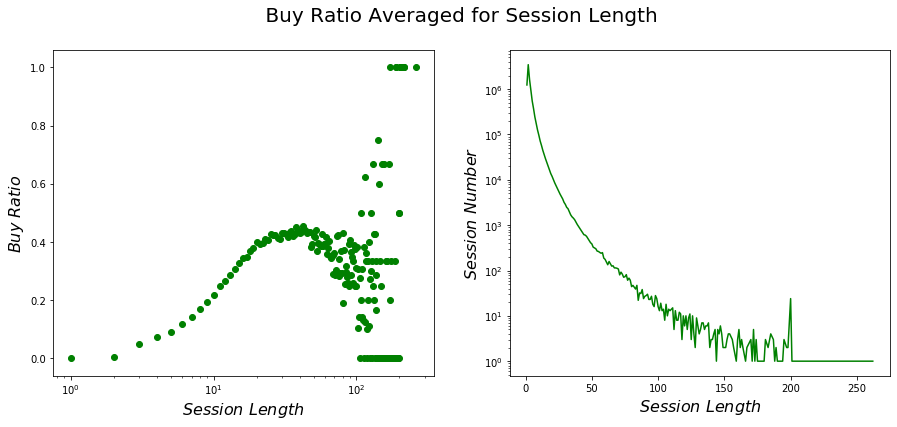

<Figure size 576x288 with 0 Axes>

In [246]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Session Length', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


fig = plt.figure(figsize=(8,4))
ax1.scatter(len_aggr.length,len_aggr.ratio,color='g')
ax1.set_ylabel('$Buy\ Ratio$',fontsize=16)
ax1.set_xlabel('$Session\ Length$',fontsize=16)
ax1.set_xscale('log')

ax2.plot(len_aggr.length,len_aggr.len_num,color='g')
ax2.set_yscale('log')
ax2.set_ylabel('$Session\ Number$',fontsize=16)
ax2.set_xlabel('$Session\ Length$',fontsize=16)


plt.show()

In [247]:
dwell_max=union.groupby('sessionID')['ts'].max().reset_index(name='max')
dwell_min=union.groupby('sessionID')['ts'].min().reset_index(name='min')

session_dwell=pd.merge(dwell_max,dwell_min,on='sessionID')
session_dwell['dwell']=(session_dwell['max']-session_dwell['min']).astype('timedelta64[m]')

In [248]:
session_dwell=pd.merge(session_dwell,session_status,on='sessionID')

In [249]:
dwell_buys=session_dwell.groupby('dwell')['status'].sum().reset_index(name='buys')
dwell_num=session_dwell.groupby('dwell')['status'].count().reset_index(name='dwell_num')
dwell_aggr=pd.merge(dwell_buys,dwell_num,on='dwell')
dwell_aggr['ratio']=dwell_aggr.buys/dwell_aggr.dwell_num

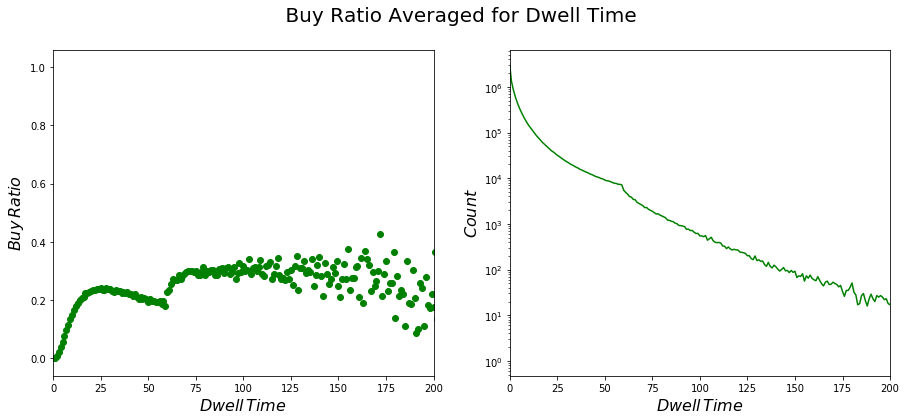

<Figure size 576x288 with 0 Axes>

In [250]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Dwell Time', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


fig = plt.figure(figsize=(8,4))
ax1.scatter(dwell_aggr.dwell,dwell_aggr.ratio,color='g')
ax1.set_ylabel('$Buy\,Ratio$',fontsize=16)
ax1.set_xlabel('$Dwell\, Time$',fontsize=16)
# ax1.set_xscale('log')
ax1.set_xlim(0,200)


ax2.plot(dwell_aggr.dwell,dwell_aggr.dwell_num,color='g')
ax2.set_yscale('log')
ax2.set_ylabel('$Count$',fontsize=16)
ax2.set_xlabel('$Dwell\, Time$',fontsize=16)
ax2.set_xlim(0,200)

plt.show()

In [251]:
### ts to datetime
# union['ts']=pd.to_datetime(union.ts,infer_datetime_format=True)
union['day']=union.ts.dt.day

In [252]:
# Buy ratio averaged for day
day_info=union.groupby(['day','status'])['sessionID'].nunique().reset_index(name='count')
day_click=day_info[day_info['status']==0]
day_buy=day_info[day_info['status']==1]
day_info=pd.merge(day_click,day_buy,on='day')
day_info['ratio']=day_info['count_y']/day_info['count_x']

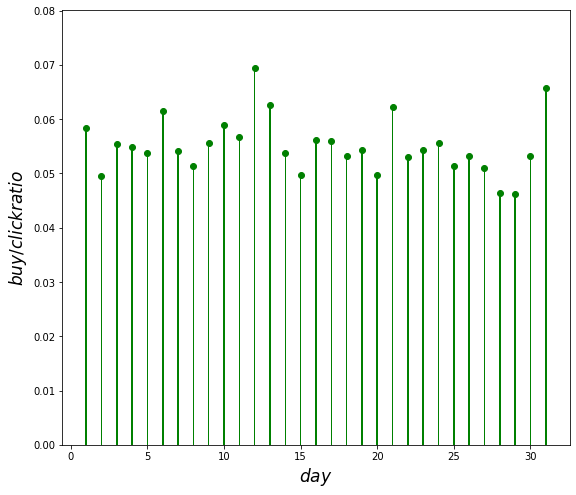

In [253]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1.scatter(day_info['day'],day_info['ratio'],color='g')
ax1.bar(day_info['day'],day_info['ratio'],width=0.1,color='g')


ax1.set_xlabel('$day$', fontsize=17)
ax1.set_ylabel('$buy/click ratio$', fontsize=17)
plt.show()

In [254]:
union['month'] = union.ts.dt.month

In [255]:
# Buy ratio averaged for hour
month_info=union.groupby(['month','status'])['sessionID'].nunique().reset_index(name='count')
month_click=month_info[month_info['status']==0]
month_buy=month_info[month_info['status']==1]
month_info=pd.merge(month_click,month_buy,on='month')
month_info['ratio']=month_info['count_y']/month_info['count_x']

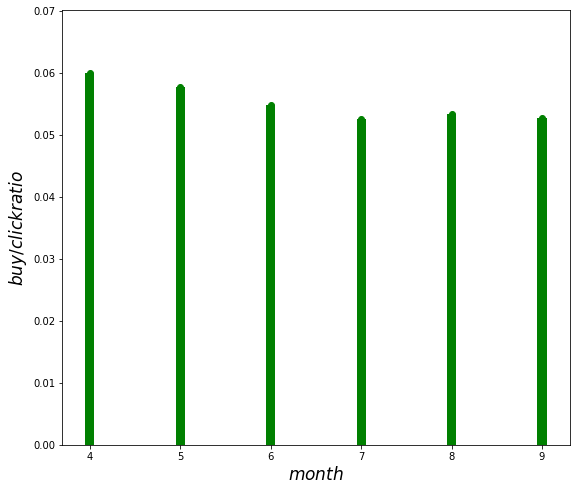

In [256]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1.scatter(month_info['month'],month_info['ratio'],color='g')
ax1.bar(month_info['month'],month_info['ratio'],width=0.1,color='g')


ax1.set_xlabel('$month$', fontsize=17)
ax1.set_ylabel('$buy/click ratio$', fontsize=17)
plt.show()

In [257]:
union['total_price'] = union['price'] * union['quantity']